# Projet 3 : Anticipez les besoins en consommation électrique de bâtiments

Ce projet consiste à l'analyse de données d'énergie et de CO2 de bâtiments non destinés à l'habitation. Le but de se projet est de créer un modèle pour estimer les consommation d'énergie ainsi que les émissions de CO2 de bâtiment pour lesquels les mesures n'ont pas encore été effectuées. Les données viennent de la ville de Seattle https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv.

Le but est de prédire les variables : GHGEmissions(MetricTonsCO2e) et SiteEnergyUse(kBtu)

Plus de documentation : 

http://www.seattle.gov/environment/climate-change/buildings-and-energy/energy-benchmarking

## Notebook 2 : Modélisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Modèles
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

# Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

In [2]:
seed = 0

## Chargement des données

In [3]:
X_train_knn = pd.read_csv('data/X_train_knn.csv', sep=';')
X_test_knn = pd.read_csv('data/X_test_knn.csv', sep=';')
y_train_knn = pd.read_csv('data/y_train_knn.csv', sep=';')
y_test_knn = pd.read_csv('data/y_test_knn.csv', sep=';')

In [4]:
print(f'X_train_knn : {X_train_knn.shape}')
print(f'X_test_knn : {X_test_knn.shape}')
print(f'y_train_knn : {y_train_knn.shape}')
print(f'y_test_knn : {y_test_knn.shape}')

X_train_knn : (1252, 15)
X_test_knn : (313, 15)
y_train_knn : (1252, 2)
y_test_knn : (313, 2)


On définit dans un premier temps les variables catégoriques et numériques.

In [5]:
X_train_knn.loc[:,'ZipCode'] = X_train_knn.loc[:,'ZipCode'].astype('object')
#X_train_knn.loc[:,'Gas'] = X_train_knn.loc[:,'Gas'].astype('object')
#X_train_knn.loc[:,'Steam'] = X_train_knn.loc[:,'Steam'].astype('object')

In [6]:
X_train_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PrimaryPropertyType        1252 non-null   object 
 1   CouncilDistrictCode        1252 non-null   float64
 2   Neighborhood               1252 non-null   object 
 3   PropertyGFATotal           1252 non-null   float64
 4   PropertyGFAParking         1252 non-null   float64
 5   PropertyGFABuilding(s)     1252 non-null   float64
 6   LargestPropertyUseTypeGFA  1252 non-null   float64
 7   ENERGYSTARScore            1252 non-null   float64
 8   NumberofFloors             1252 non-null   float64
 9   Latitude                   1252 non-null   float64
 10  Longitude                  1252 non-null   float64
 11  ZipCode                    1252 non-null   object 
 12  Gas                        1252 non-null   float64
 13  Steam                      1252 non-null   float

In [7]:
y_train_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SiteEnergyUse(kBtu)           1252 non-null   float64
 1   GHGEmissions(MetricTonsCO2e)  1252 non-null   float64
dtypes: float64(2)
memory usage: 19.7 KB


## Modélisation de la consommation d'énergie

### Sélection des données

Dans un premier temps on fait une copie des variables.

In [8]:
X_train = X_train_knn.copy()
X_test = X_test_knn.copy()
y_train = y_train_knn.copy()
y_test = y_test_knn.copy()

On supprime la variable ENERGYSTARScore.

In [9]:
X_train = X_train.drop(axis='columns', columns='ENERGYSTARScore')
X_test = X_test.drop(axis='columns', columns='ENERGYSTARScore')

On supprime la variable CO2.

In [10]:
y_train = y_train.drop(axis='columns', columns='GHGEmissions(MetricTonsCO2e)')
y_test = y_test.drop(axis='columns', columns='GHGEmissions(MetricTonsCO2e)')

On convertit ensuite les sorties y en np.ndarray

In [11]:
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

.to_numpy() permet de passer d'un dataframe à un np.ndarray

.ravel() permet de changer l'attribut shape passant de (x,1) à (x,)

In [12]:
y_test.shape

(313,)

### Modèles à tester

On définit une liste des modèles que l'on va tester pour faire de la régression linéaire.

In [13]:
regressors = [
    DummyRegressor(strategy='mean'),
    linear_model.LinearRegression(),
    linear_model.Ridge(random_state=seed),
    linear_model.Lasso(random_state=seed),
    RandomForestRegressor(random_state=seed),
    GradientBoostingRegressor(random_state=seed)
    ]


### Preprocessing

Les données ne peuvent pas être utilisées directement par les modèles car :
* les variables catégorielles sont composées de texte
* les variables numériques n'ont pas la même échelle

On applique donc :
* un encodage pour les variables catégorielles
* une normalisation pour les variables numériques

In [14]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Evaluation

Pour evaluer les modèles entre eux nous allons effectuer une cross validation avec 5 folds. 
Cela signifie que l'on va entrainer puis prédire 5 fois de suite avec des jeu de données différents. Cela permet de s'assurer de la stabilité du score lorsque le jeu de données change. Nous allons stocker les résultats moyens dans deux dataframes un pour le score et l'autre pour le temps d'excecution.

In [15]:
df_score = pd.DataFrame(columns=['model','r2','score'])
df_time = pd.DataFrame(columns=['model','temps en s','time'])

On effectue ensuite une cross validation pour chaque élément de la liste de modèles. 

In [16]:
for i, regressor in zip(range(0,len(regressors)*2,2), regressors):
    model_name = str(regressor)[:-2]
    print(model_name)
    model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', regressor)])
    cv_results = cross_validate(model, X_train, y_train, scoring='r2', cv=5, return_train_score=True)
    # On stocke les résultats
    df_score.loc[i] = [model_name,cv_results['train_score'].mean(),'train']
    df_score.loc[i+1] = [model_name,cv_results['test_score'].mean(),'validation']
    df_time.loc[i] = [model_name,cv_results['fit_time'].mean(),'fit']
    df_time.loc[i+1] = [model_name,cv_results['score_time'].mean(),'score']
    print("validation score : %.3f" % cv_results['test_score'].mean())

DummyRegressor
validation score : -0.006
LinearRegression
validation score : 0.683
Ridge(random_state=
validation score : 0.703
Lasso(random_state=


/home/hugo/anaconda3/envs/projet3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 814372073774152.0, tolerance: 35047756907383.72
  model = cd_fast.sparse_enet_coordinate_descent(
/home/hugo/anaconda3/envs/projet3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2301761922626336.0, tolerance: 31239269235905.54
  model = cd_fast.sparse_enet_coordinate_descent(
/home/hugo/anaconda3/envs/projet3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3086272777261872.0, tolerance: 29603774607913.54
  model = cd_fast.sparse_enet_coordinate_descent(
/home/hugo/anaconda3/envs/pro

validation score : 0.683
RandomForestRegressor(random_state=
validation score : 0.677
GradientBoostingRegressor(random_state=
validation score : 0.730


On peut maintenant visualiser les résultats. 

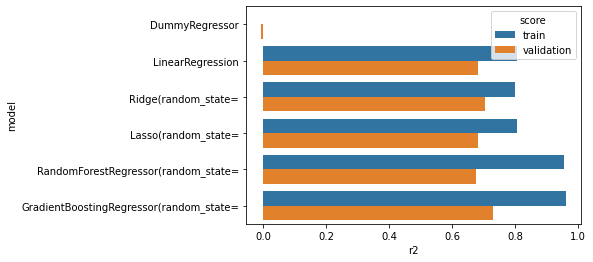

In [17]:
sns.barplot(x='r2', y='model', hue='score', data=df_score)

[None]

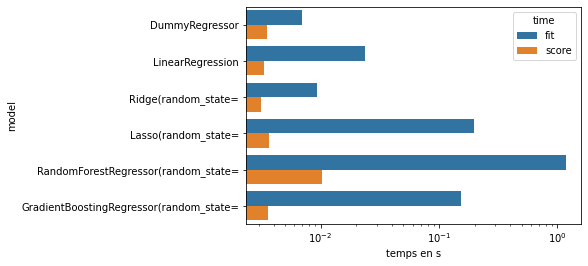

In [18]:
g = sns.barplot(x='temps en s', y='model', hue='time', data=df_time)
g.set(xscale="log")

Les modèles obtenant le meilleur r2 sont les modèles de regression ridge et de gradient boosting. D'un point de vue temps de calcul et temps d'excécution les résultats sont très dispersés, il faut même utiliser une échelle logarithmique pour pouvoir comparer les résultats. Le modèle de random forest est le plus lourd en temps de calcul. Ensuite viennent les modèles gradient boosting et lasso. Enfin, les modèles de regression linéaire et ridge sont bien plus léger, ils sont de 10 à 100 fois plus rapides.

On peut donc conclure que les deux modèles que nous allons étudier en détails sont :
* Ridge
* Gradient Boosting

### Comparaison des meilleurs modèles

Pour l'optimisation on utilise la fonction GridSearchCV qui permet de tester une liste d'hyper-paramètres en cross validation. 

Remarque : le nom du parametre doit commencer par nom du modèle + __ lorsque l'on utilise pipeline. ex : model__alpha

In [19]:
grid_list = []

#### Ridge

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [20]:
ri_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', linear_model.Ridge(random_state=seed))])

In [21]:
ri_pipeline['model'].get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': 0,
 'solver': 'auto',
 'tol': 0.001}

On sélectionne différentes valeurs pour les hyper-paramètres. Toutes les combinaisons seront testées.

In [22]:
param_grid = {
    'model__alpha': [0.1, 0.5, 1.0, 5, 10.0],
    'model__fit_intercept': [True, False]
}

On effectue GridSearchCV et on stocke les résultats dans une liste.

In [23]:
grid = GridSearchCV(ri_pipeline, param_grid, scoring='r2', cv=5, return_train_score=True)
grid.fit(X_train, y_train)
grid_list.append(grid)

#### Gradient Boosting

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [24]:
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', GradientBoostingRegressor(random_state=seed))])

Il existe de nombreux hyper-paramètres pour le model de gradient boosting.

In [25]:
gb_pipeline['model'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

On sélectionne les hyper-paramètres suivant :

In [26]:
param_grid = {
    'model__max_depth': [None, 5, 10],    
    'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 5, 10],
    'model__min_samples_split': [2, 10, 20],
    'model__n_estimators': [50, 100, 150]
}

On effectue GridSearchCV et on stocke les résultats dans une liste.

In [27]:
grid = GridSearchCV(gb_pipeline, param_grid, scoring='r2', cv=5, return_train_score=True)
grid.fit(X_train, y_train)
grid_list.append(grid)

On écrit une fonction qui va retourner le meilleur score de cross-validation pour chaque modèle. Cette fonction retourne les résultats sous forme de dataframe.

In [28]:
def best_grid(grid_list):
    df_score = pd.DataFrame(columns=['model','r2','score'])
    df_time = pd.DataFrame(columns=['model','temps en s','time'])
    
    for i, grid in zip(range(0,len(grid_list)*2,2), grid_list):
        best_model = grid.best_estimator_
        model_name = str(best_model['model']).split('(')[0]
        print(model_name)
        best_model_index = grid.best_index_
        train_score = grid.cv_results_['mean_train_score'][best_model_index]
        test_score = grid.cv_results_['mean_test_score'][best_model_index]
        fit_time = grid.cv_results_['mean_fit_time'][best_model_index]
        score_time = grid.cv_results_['mean_score_time'][best_model_index]
        # On stocke les résultats
        df_score.loc[i] = [model_name,train_score,'train']
        df_score.loc[i+1] = [model_name,test_score,'validation']
        df_time.loc[i] = [model_name,fit_time,'fit']
        df_time.loc[i+1] = [model_name,score_time,'score']
        print("Meilleur score validation : %.3f" % df_score.loc[i+1,'r2'])

    return df_score, df_time

In [29]:
df_score, df_time = best_grid(grid_list)

Ridge
Meilleur score validation : 0.703
GradientBoostingRegressor
Meilleur score validation : 0.739


On peut maintenant visualiser les meilleurs résultats moyens obtenus pour chaque modèle.

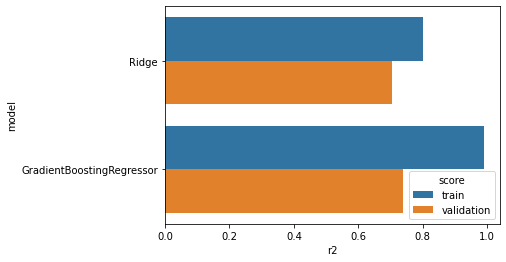

In [30]:
sns.barplot(x='r2', y='model', hue='score', data=df_score)

[None]

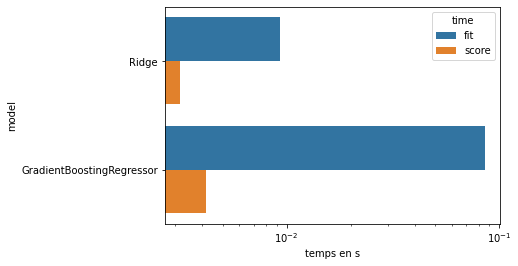

In [31]:
g = sns.barplot(x='temps en s', y='model', hue='time', data=df_time)
g.set(xscale="log")

On constate donc que le modèle ayant le meilleur score de validation est le modèle de gradient boosting. Pour avoir une idée des meilleurs hyper-paramètres ont peut afficher ceux qui ont été utilisés pour obtenir le meilleur score.

In [32]:
grid_list[1].best_estimator_['model'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [33]:
grid_list[1].best_params_

{'model__max_depth': 5,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

On stocke ce modèle.

In [34]:
model_gridcv = GradientBoostingRegressor(max_depth=grid_list[1].best_params_['model__max_depth'],
                                         max_features=grid_list[1].best_params_['model__max_features'],
                                         min_samples_leaf=grid_list[1].best_params_['model__min_samples_leaf'],
                                         min_samples_split=grid_list[1].best_params_['model__min_samples_split'],
                                         n_estimators=grid_list[1].best_params_['model__n_estimators'],
                                         random_state=seed)

### Optimisation du meilleur modèle

On sait maintenant que parmis nos 6 modèles de départ le modèle de gradient boosting permet d'obtenir le meilleur score. On connait également une combinaison d'hyper-paramètres qui permet d'avoir un bon score. On va donc maintenant essayer d'obtenir un meilleur score de cross-validation en cherchant à pousser l'optimisation en 3 étapes :
* Optimisation de l'encodage
* Optimisation plus complète des hyper-paramètres
* Optimisation des features

doc très intéressant : https://medium.com/kaggle-blog/2017-data-science-bowl-predicting-lung-cancer-2nd-place-solution-write-up-daniel-hammack-and-79dc345d4541

#### Etape 1 :  Optimisation de l'encodage des variables catégoriques

Il existe de nombreuses méthodes pour faire de l'encodage de variable catégoriques. Les plus connues sont :
* Ordinal
* One Hot

Plus d'informations : https://pypi.org/project/category-encoders/

https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

https://towardsdatascience.com/an-easier-way-to-encode-categorical-features-d840ff6b3900

Nous allons utiliser la librairie category-encoder et essayer différentes méthodes sur la variable Neighborhood.

In [35]:
X = X_train_knn['Neighborhood'].head(n=7)
print(X)

0                NORTHWEST
1                 DOWNTOWN
2         GREATER DUWAMISH
3    MAGNOLIA / QUEEN ANNE
4                     EAST
5                    NORTH
6                 DOWNTOWN
Name: Neighborhood, dtype: object


##### Ordinal encoder

La méthode Ordinal stocke l'information sur 1 seule colonne. Chaque catégorie est remplacée par un nombre entier.

In [36]:
encoder = ce.ordinal.OrdinalEncoder()
encoder.fit_transform(X)

,Neighborhood
0,1
1,2
2,3
3,4
4,5
5,6
6,2


Caractéristiques : 
* Avantage : utilise une seule colonne
* Inconvénient : créé une relation d'ordre entre les catégories ce qui peut être pénalisant en fonction du modèle utilisé.

##### One Hot Encoder

La méthode One Hot stocke l'information sur k colonnes, k étant le nombre de catégories. L'information est stockée sous la forme de 0 et de 1. Pour une valeur d'index donné on retrouve une seule colonne ayant la valeur 1. Cette colonne correspond à la catégorie pour l'index donné.

In [37]:
encoder = ce.one_hot.OneHotEncoder()
encoder.fit_transform(X)

,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,0,0,1,0
5,0,0,0,0,0,1
6,0,1,0,0,0,0


Dans cet exemple, 
* Neighborhood_1 = LAKE UNION
* Neighborhood_2 = SOUTHEAST
* Neighborhood_3 = NORTHWEST
* Neighborhood_4 = GREATER DUWAMISH
* Neighborhood_5 = MAGNOLIA / QUEEN ANNE

Caractéristiques :
* Avantage : pas de relation d'ordre entre les catégories
* Inconvénient : crée un nombre de variables important, ce qui peut poser problème en fonction du modèle

##### Sum Coding

La méthode Sum Coding stocke l'information sur k-1 colonne k étant le nombre de catégorie. Cela est possible car une colonne est remplacée par la valeur -1 sur toute la ligne. L'information est stockée sous forme de 1, 0 et 1.

In [38]:
encoder = ce.sum_coding.SumEncoder()
encoder.fit_transform(X)

,intercept,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4
0,1,1.0,0.0,0.0,0.0,0.0
1,1,0.0,1.0,0.0,0.0,0.0
2,1,0.0,0.0,1.0,0.0,0.0
3,1,0.0,0.0,0.0,1.0,0.0
4,1,0.0,0.0,0.0,0.0,1.0
5,1,-1.0,-1.0,-1.0,-1.0,-1.0
6,1,0.0,1.0,0.0,0.0,0.0


Dans cet exemple,
* Neighborhood_0 : LAKE UNION
* Neighborhood_1 : SOUTHEAST
* Neighborhood_2 : NORTHWEST
* Neighborhood_3 : GREATER DUWAMISH

et la catégorie MAGNOLIA / QUEEN ANNE est remplacée par la ligne de -1 que l'on peut voir à la ligne 5.

Remarque : cette méthode est similaire à la méthode dummy dans laquelle la catégorie est remplacée par une ligne de 0.

Caractéristiques : 
* Avantage : Il n'y a pas de relation d'ordre entre les variables
* Inconvénient : On crée un nombre de variable important

##### Comparaison de l'encodage sur le modèle de gradient boosting

Liste des méthodes d'encodage que l'on va tester.

In [39]:
encoder_list = [ce.one_hot.OneHotEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.sum_coding.SumEncoder]

On effectue une cross validation pour chaque méthode d'encodage.

In [40]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

for encoder in encoder_list:

    categorical_transformer = Pipeline(steps=[('encoder', encoder())])

    preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', model_gridcv)])
    cv_results = cross_validate(model, X_train, y_train, scoring='r2', cv=5)
    print(encoder)
    print("average validation score: %.3f" % cv_results['test_score'].mean())

<class 'category_encoders.one_hot.OneHotEncoder'>
average validation score: 0.740
<class 'category_encoders.ordinal.OrdinalEncoder'>
average validation score: 0.660
<class 'category_encoders.sum_coding.SumEncoder'>
average validation score: 0.711


Pour la suite de cette étude nous utiliserons ma méthode One Hot.

In [41]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', ce.one_hot.OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', GradientBoostingRegressor(random_state=seed))])

#### Etape 2 :  Plage d'hyper-paramètres assez large

D'après les résultats des deux grid search, le meilleur modèle est le gradient boosting. Nous allons maintenant chercher à optimiser plus loin les hyper paramètres. Pour cela on va utiliser la méthode de random search.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

La différence entre RandomizedSearchCV et GridSearchCV est que l'on spécifie beaucoup plus de valeur dans notre grille d'hyper-paramètres avec RandomizedSearchCV. Cela prendrait trop de temps de d'entrainer et de tester l'ensemble des configurations, c'est pourquoi on fixe un nombre d'itérations à essayer de manière aléatoire.

On définit la plage à étudier des hyper-paramètres en se basant sur les valeurs par défaut et les valeurs ayant donné le meilleur score avec GridSearchCV :
* learning_rate : [0.05 à 0.15 pas de 0.01]
* n_estimators : [100 à 300 pas de 1]
* min_samples_split :  [15 à 45 pas de 1]
* min_samples_leaf : [1 à 4 pas de 1]
* max_depth : [1 à 9 pas de 1]
* max_features : [1 à 7 pas de 1]
* max_leaf_nodes : [None]

In [42]:
param_grid = {
    'model__learning_rate':[x for x in np.linspace(start = 0.05, stop = 0.15, num = 11)],
    'model__n_estimators':[int(x) for x in np.linspace(start = 100, stop = 300, num = 201)],
    'model__min_samples_split': [int(x) for x in np.linspace(start = 15, stop = 45, num = 31)],
    'model__min_samples_leaf': [1,2,3,4],
    'model__max_depth': [int(x) for x in np.linspace(start=1, stop=9, num=9)],
    'model__max_features': [int(x) for x in np.linspace(start=1, stop=7, num=7)],
    'model__max_leaf_nodes': [None]
}

In [43]:
grid = RandomizedSearchCV(gb_pipeline, param_distributions=param_grid, n_iter=1000, scoring='r2', cv=5, return_train_score=True, random_state=seed)
grid.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['CouncilDistrictCode', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'NumberofFloors',
       'Latitude', 'Longitude', 'Gas', 'Steam', 'BuildingAge'],
      dtype='o...
                                        'model__min_samples_leaf': [1, 2, 3, 4],
                                        'model__min_samples_split': [15, 16, 17,
                                                                     18, 19, 20,
                                                

In [44]:
grid.best_score_

0.7494691562853215

In [45]:
grid.best_params_

{'model__n_estimators': 298,
 'model__min_samples_split': 22,
 'model__min_samples_leaf': 4,
 'model__max_leaf_nodes': None,
 'model__max_features': 6,
 'model__max_depth': 9,
 'model__learning_rate': 0.07}

Ce jeu d'hyper-paramètres permet d'avoir le meilleur score parmi les 1000 itérations qui ont été testées. On stocke donc ce modèle.

In [46]:
gb_best_params = GradientBoostingRegressor(n_estimators=298,
                                           min_samples_split=22,
                                           min_samples_leaf=4,
                                           max_leaf_nodes=None,
                                           max_features=6,
                                           max_depth=9,
                                           learning_rate=0.07,
                                           random_state=seed)

In [47]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', ce.one_hot.OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

gb_pipeline_opti = Pipeline(steps=[('preprocessor', preprocessor),('model', gb_best_params)])
cv_results = cross_validate(gb_pipeline_opti, X_train, y_train, scoring='r2', cv=5)
print("average validation score: %.3f" % cv_results['test_score'].mean())

average validation score: 0.749


#### Etape 3 : Features ayant le plus d'importance

Dans cette étape nous allons utiliser le meilleur modèle dont on dispose et déterminer l'importance des features sur ce modèle. Pour cela nous allons utiliser la fonction permutation_importance de scikit-learn. Le principe est que l'on mélange les valeurs d'une feature et l'on regarde l'impact sur le score. 

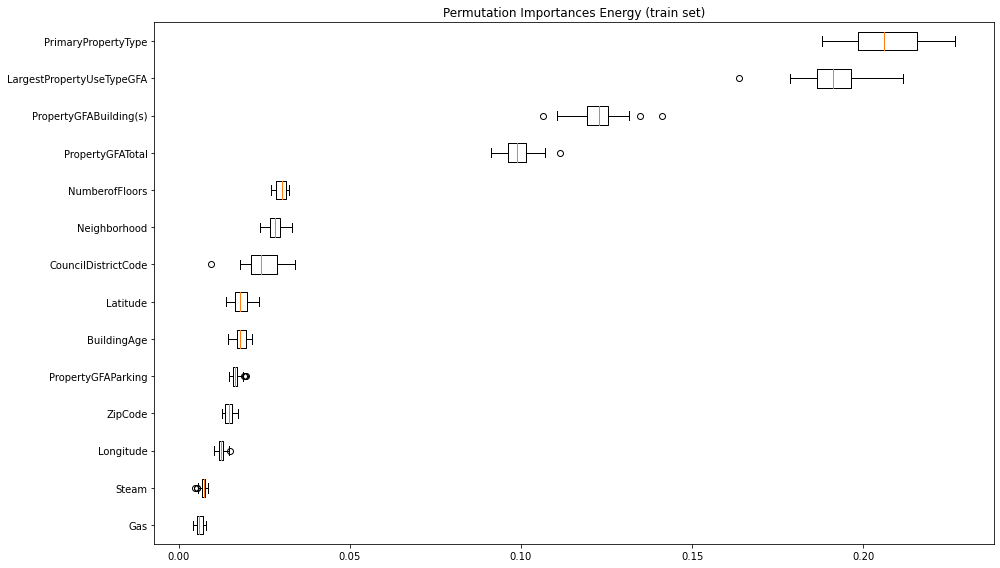

In [48]:
gb_pipeline_opti.fit(X_train, y_train)
result = permutation_importance(gb_pipeline_opti, X_train, y_train, n_repeats=30, n_jobs=2, random_state=seed)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14,8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances Energy (train set)")
fig.tight_layout()
plt.show()


Point important ce classement entre les features dépend du modèle, un mauvais modèle peut donner de l'importance à une feature qui n'est pas importante. Il faut donc prendre du recul sur ce classement car un autre modèle avec les mêmes performances pourrait donner un classement différent.

On constate plusieurs choses :
* PrimaryPropertyType est la variable qui a le plus d'impact sur ce modèle
* Ensuite viennent les variables de surface (excepté PropertyGFAParking)  : 
    * LargestPropertyUseTypeGFA
    * surfacePropertyGFABuilding(s) 
    * PropertyGFATotal

* la variable BuildingAge n'apporte presque rien alors que l'on avait vu dans la phase exploratoire que les bâtiments consommait plus avec le temps car la surface des bâtiments augmente. On peut essayer de créer une variable combinant l'âge du bâtiment et la surface
* les variables Steam et Gas sont également dans le bas du classement

On va maintenant ajouter ou enlever des features afin de voir l'impact sur le score.

##### suppression de features

On fait le choix de conserver une seule variable de surface : PropertyGFABuilding(s)

In [49]:
X_train_surface = X_train.drop(axis='columns', columns=['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'PropertyGFAParking'])
X_test_surface = X_test.drop(axis='columns', columns=['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'PropertyGFAParking'])

##### ajout de features

On construit ensuite des fonctions pour ajouter des variables. Pendant l'exploration on a constaté que les consommation d'énergie moyenne sont différentes entre les groupes de bâtiments ayant une même classe d'âge. La surface ayant un rôle important, en combinant ces deux variables on pourrait peut-être avoir de meilleurs performances. De plus, diviser par une surface ou par un age permet de normaliser les données. On crée donc deux variables : 
* BuildingAge/PropertyGFABuilding(s)
* PropertyGFABuilding(s)/BuildingAge

In [50]:
def addBuildingAgeOverSurface(df):
    newdf = df.copy()
    newdf.loc[:,'BuildingAge/PropertyGFABuilding(s)'] = np.nan
    index_logic = newdf.loc[:,'PropertyGFABuilding(s)'] > 0
    newdf.loc[index_logic,'BuildingAge/PropertyGFABuilding(s)'] = newdf.loc[index_logic,'BuildingAge'] / newdf.loc[index_logic,'PropertyGFABuilding(s)']
    
    return newdf

In [51]:
def addSurfaceOverBuildingAge(df):
    newdf = df.copy()
    newdf.loc[:,'PropertyGFABuilding(s)/BuildingAge'] = np.nan
    index_logic = newdf.loc[:,'BuildingAge'] > 0
    newdf.loc[index_logic,'PropertyGFABuilding(s)/BuildingAge'] = newdf.loc[index_logic,'PropertyGFABuilding(s)'] / newdf.loc[index_logic,'BuildingAge']
    
    return newdf

In [52]:
X_train_addBoS = addBuildingAgeOverSurface(X_train)
X_test_addBoS = addBuildingAgeOverSurface(X_test)

In [53]:
X_train_addSoB = addSurfaceOverBuildingAge(X_train)
X_test_addSoB = addSurfaceOverBuildingAge(X_test)

##### Preprocessing

Comme on change les features il faut faire le travail de preprocessing pour chaque nouveau modèle. Pour gagner du temps on écrit une fonction qui prend en entrée un modèle et un set de features afin de faire créer le pipeline. 

In [54]:
def preprocessingPipeline(X_train, model):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=5, weights='distance')),('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),('onehot', ce.one_hot.OneHotEncoder())])

    preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    
    return gb_pipeline

##### Evaluation

On écrit également une fonction qui effectue une cross-validation et ajoute les résultats dans un dataframe.

In [55]:
def evaluationPipeline(X_train, y_train, model, model_name, df_score):
    gb_pipeline = preprocessingPipeline(X_train, model)
    cv_results = cross_validate(gb_pipeline, X_train, y_train, scoring='r2', cv=5, return_train_score=True)
    df_score = df_score.append({'model': model_name, 'r2': cv_results['train_score'].mean(), 'score': 'train'}, ignore_index=True)
    df_score = df_score.append({'model': model_name, 'r2': cv_results['test_score'].mean(), 'score': 'test'}, ignore_index=True)
           
    return df_score

##### Comparaison avec cross-validation

On compare avec la cross-validation 4 modèles de gradient boosting ayant le meilleur jeu d'hyper-paramètres que l'on a obtenu à la suite de RandomizedSeachCV. Les différences entre ces modèles se trouvent dans les features :
* modèle optimisé : modèle de base avec 14 features 
* modèle optimisé une seule surface : modèle de base - 3 features de surface 
* modèle optimisé BuildingAge over Surface : modèle de base + 1 feature BuildingAge/PropertyGFABuilding(s)
* modèle optimisé Surface over BuildingAge : modèle de base + 1 feature PropertyGFABuilding(s)/BuildingAge

In [56]:
df_score = pd.DataFrame(columns=['model','r2','score'])
df_score = evaluationPipeline(X_train, y_train, gb_best_params, 'Modèle optimisé', df_score)
df_score = evaluationPipeline(X_train_surface, y_train, gb_best_params, 'Modèle optimisé \n une seule surface', df_score)
df_score = evaluationPipeline(X_train_addBoS, y_train, gb_best_params, 'Modèle optimisé \n BuildingAge over Surface', df_score)
df_score = evaluationPipeline(X_train_addSoB, y_train, gb_best_params, 'Modèle optimisé \n Surface over BuildingAge', df_score)

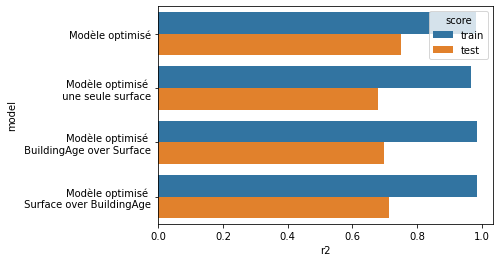

In [57]:
sns.barplot(x='r2', y='model', hue='score', data=df_score)

In [58]:
df_score.loc[df_score.score == 'test',:]

,model,r2,score
1,Modèle optimisé,0.749469,test
3,Modèle optimisé \n une seule surface,0.680006,test
5,Modèle optimisé \n BuildingAge over Surface,0.698251,test
7,Modèle optimisé \n Surface over BuildingAge,0.713224,test


On constate que le modèle de base est celui obtenant le meilleur score de cross-validation. Les ajouts et suppression de features n'ont pas permis d'amélioration du score de cross-validation. On conserve donc le modèle optimisé avec les 14 features pour faire l'évaluation sur le test final.

### Evaluation finale

Dans cette partie nous allons évaluer notre meilleur modèle sur le jeu de test.

#### Meilleur modèle

On redéfinit notre meilleur modèle.

In [59]:
gb_best_params = GradientBoostingRegressor(n_estimators=298,
                                           min_samples_split=22,
                                           min_samples_leaf=4,
                                           max_leaf_nodes=None,
                                           max_features=6,
                                           max_depth=9,
                                           learning_rate=0.07,
                                           random_state=seed)

In [60]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', ce.one_hot.OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

gb_pipeline_opti = Pipeline(steps=[('preprocessor', preprocessor),('model', gb_best_params)])
cv_results = cross_validate(gb_pipeline_opti, X_train, y_train, scoring='r2', cv=5)
print("average validation score: %.3f" % cv_results['test_score'].mean())

average validation score: 0.749


#### Learning Curve

On s'intéresse également à la courbe d'apprentissage qui permet de voir le score en fonction de la quantité de données utilisées.

In [61]:
from sklearn.model_selection import learning_curve

def plotLearningCurve(model, X_train, y_train):
    N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1,1,10), cv = 5)
    plt.plot(N, train_score.mean(axis=1), label='train')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.legend()

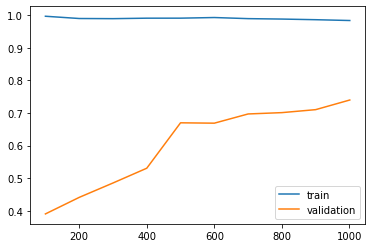

In [62]:
plotLearningCurve(gb_pipeline_opti, X_train, y_train)

On constate que le score de cross-validation n'est pas encore stabilisé ce qui signifie que avoir plus de données pourrait permettre d'améliorer le score.

#### Evaluation sur le test set

On effectue l'evaluation finale sur le jeu de test.

In [63]:
gb_pipeline_opti.fit(X_train, y_train)
y_pred = gb_pipeline_opti.predict(X_test)
test_score = r2_score(y_test, y_pred)
print(f'Le score r2 du meilleur modèle est de {test_score:0.2f}')

Le score r2 du meilleur modèle est de 0.44


#### Evaluation du model selon une variable catégorielle

On calcule l'erreur relative que l'on va observer en fonction de l'usage des bâtiments.

In [64]:
df_score = X_test_knn.copy()
df_score.loc[:,'erreur relative sur la consommation d\'énergie (%)'] = (y_pred - y_test)/abs(y_test) * 100
print('erreur relative moyenne (%) :')
print(round(df_score['erreur relative sur la consommation d\'énergie (%)'].mean(),2))

erreur relative moyenne (%) :
67.11


In [65]:
df_score.loc[:,'erreur relative sur la consommation d\'énergie (%)'].mean()

67.10752403195666

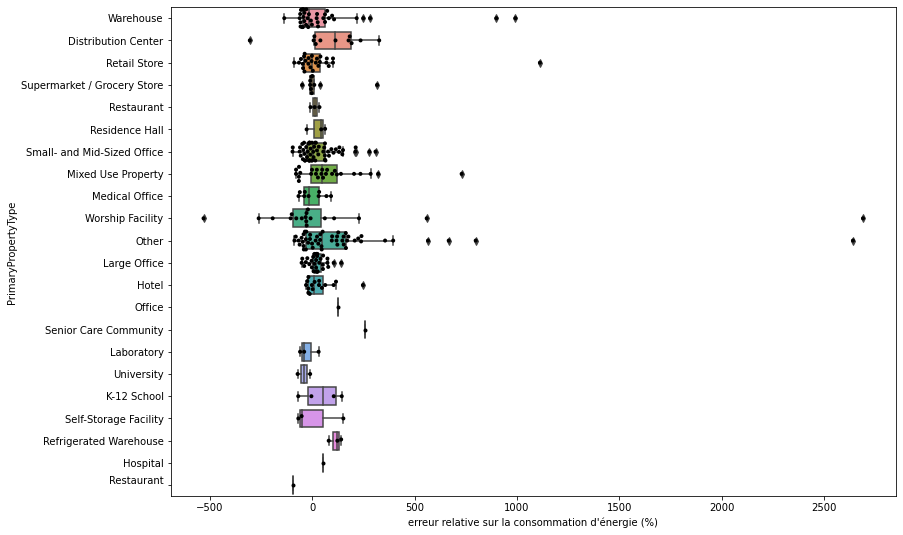

In [66]:
plt.figure(figsize=(13,9))
#sns.set(font_scale=1.6)
sns.boxplot(x='erreur relative sur la consommation d\'énergie (%)', y='PrimaryPropertyType', data=df_score)
sns.swarmplot(x='erreur relative sur la consommation d\'énergie (%)', y='PrimaryPropertyType', data=df_score, color='black', size=4)

On constate que l'erreur relative est très variable selon l'usage des bâtiments. Pour les bâtiments de bureau l'erreur semble acceptable. On constate que pour certains usages l'erreur peut être très importante plus de 1000 % ce qui signifie que l'on fait une prédiction 10 fois plus élevée que la réalité. 

On peut visualiser dans le détail l'erreur relative pour les hôtels et les bâtiments de bureau.

In [67]:
index_logic = (df_score.loc[:,'PrimaryPropertyType'] == 'Small- and Mid-Sized Office') | (df_score.loc[:,'PrimaryPropertyType'] == 'Large Office') | (df_score.loc[:,'PrimaryPropertyType'] == 'Hotel')

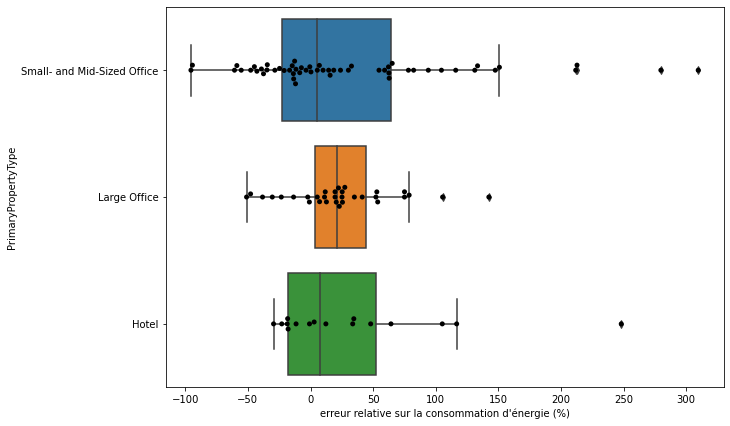

In [68]:
plt.figure(figsize=(10,7))
#sns.set(font_scale=1.4)
sns.boxplot(x='erreur relative sur la consommation d\'énergie (%)', y='PrimaryPropertyType', data=df_score.loc[index_logic,:])
sns.swarmplot(x='erreur relative sur la consommation d\'énergie (%)', y='PrimaryPropertyType', data=df_score.loc[index_logic,:], color='black')

In [69]:
df_score.loc[index_logic,['erreur relative sur la consommation d\'énergie (%)','PrimaryPropertyType']].groupby('PrimaryPropertyType').mean()

,erreur relative sur la consommation d'énergie (%)
PrimaryPropertyType,
Hotel,34.090073
Large Office,23.732526
Small- and Mid-Sized Office,31.627445


L'erreur relative moyenne pour ces bâtiments est comprise entre 20 et 30 % ce qui pourrait très bien être utilisé et remplacer une campagne de mesure. Tout dépend de l'objectif et de la précision nécessaire.

## Modélisation de CO2

On réalise ensuite le même travail pour les émissions de CO2.

In [70]:
X_train_knn = pd.read_csv('data/X_train_knn.csv', sep=';')
X_test_knn = pd.read_csv('data/X_test_knn.csv', sep=';')
y_train_knn = pd.read_csv('data/y_train_knn.csv', sep=';')
y_test_knn = pd.read_csv('data/y_test_knn.csv', sep=';')

In [71]:
print(f'X_train_knn : {X_train_knn.shape}')
print(f'X_test_knn : {X_test_knn.shape}')
print(f'y_train_knn : {y_train_knn.shape}')
print(f'y_test_knn : {y_test_knn.shape}')

X_train_knn : (1252, 15)
X_test_knn : (313, 15)
y_train_knn : (1252, 2)
y_test_knn : (313, 2)


On définit dans un premier temps les variables catégoriques et numériques.

In [72]:
X_train_knn.loc[:,'ZipCode'] = X_train_knn.loc[:,'ZipCode'].astype('object')
#X_train_knn.loc[:,'Gas'] = X_train_knn.loc[:,'Gas'].astype('object')
#X_train_knn.loc[:,'Steam'] = X_train_knn.loc[:,'Steam'].astype('object')

In [73]:
X_train_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PrimaryPropertyType        1252 non-null   object 
 1   CouncilDistrictCode        1252 non-null   float64
 2   Neighborhood               1252 non-null   object 
 3   PropertyGFATotal           1252 non-null   float64
 4   PropertyGFAParking         1252 non-null   float64
 5   PropertyGFABuilding(s)     1252 non-null   float64
 6   LargestPropertyUseTypeGFA  1252 non-null   float64
 7   ENERGYSTARScore            1252 non-null   float64
 8   NumberofFloors             1252 non-null   float64
 9   Latitude                   1252 non-null   float64
 10  Longitude                  1252 non-null   float64
 11  ZipCode                    1252 non-null   object 
 12  Gas                        1252 non-null   float64
 13  Steam                      1252 non-null   float

In [74]:
y_train_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SiteEnergyUse(kBtu)           1252 non-null   float64
 1   GHGEmissions(MetricTonsCO2e)  1252 non-null   float64
dtypes: float64(2)
memory usage: 19.7 KB


### Sélection des données

Dans un premier temps on fait une copie des variables.

In [75]:
X_train = X_train_knn.copy()
X_test = X_test_knn.copy()
y_train = y_train_knn.copy()
y_test = y_test_knn.copy()

On supprime la variable ENERGYSTARScore.

In [76]:
X_train = X_train.drop(axis='columns', columns='ENERGYSTARScore')
X_test = X_test.drop(axis='columns', columns='ENERGYSTARScore')

On supprime la variable consommation d'énergie.

In [77]:
y_train = y_train.drop(axis='columns', columns='SiteEnergyUse(kBtu)')
y_test = y_test.drop(axis='columns', columns='SiteEnergyUse(kBtu)')

On convertit ensuite les sorties y en np.ndarray

In [78]:
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

.to_numpy() permet de passer d'un dataframe à un np.ndarray

.ravel() permet de changer l'attribut shape passant de (x,1) à (x,)

In [79]:
y_test.shape

(313,)

### Modèles à tester

On teste les mêmes modèles de départ que pour la consommation d'énergie.

In [80]:
regressors = [
    DummyRegressor(strategy='mean'),
    linear_model.LinearRegression(),
    linear_model.Ridge(random_state=seed),
    linear_model.Lasso(random_state=seed),
    RandomForestRegressor(random_state=seed),
    GradientBoostingRegressor(random_state=seed)
    ]


### Preprocessing

On définit à nouveau l'encodage des variables catégorielles et la normalisation des variables numériques.

In [81]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Evaluation

Pour evaluer les modèles entre eux nous allons effectuer une cross validation avec 5 folds. Nous allons stocker ces résultats dans deux dataframe un pour le score et l'autre pour le temps d'excecution.

In [82]:
df_score = pd.DataFrame(columns=['model','r2','score'])
df_time = pd.DataFrame(columns=['model','temps en s','time'])

On effectue ensuite une cross validation pour chaque élément de la liste de modèles. 

In [83]:
for i, regressor in zip(range(0,len(regressors)*2,2), regressors):
    model_name = str(regressor)[:-2]
    print(model_name)
    model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', regressor)])
    cv_results = cross_validate(model, X_train, y_train, scoring='r2', cv=5, return_train_score=True)
    # On stocke les résultats
    df_score.loc[i] = [model_name,cv_results['train_score'].mean(),'train']
    df_score.loc[i+1] = [model_name,cv_results['test_score'].mean(),'validation']
    df_time.loc[i] = [model_name,cv_results['fit_time'].mean(),'fit']
    df_time.loc[i+1] = [model_name,cv_results['score_time'].mean(),'score']
    print("validation score : %.3f" % cv_results['test_score'].mean())

DummyRegressor
validation score : -0.003
LinearRegression
validation score : 0.558
Ridge(random_state=
validation score : 0.571
Lasso(random_state=
validation score : 0.581
RandomForestRegressor(random_state=
validation score : 0.632
GradientBoostingRegressor(random_state=
validation score : 0.704


On peut maintenant visualiser les résultats. 

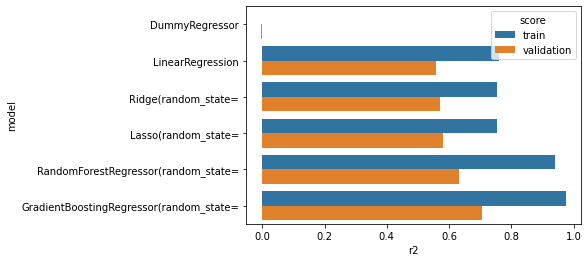

In [84]:
sns.barplot(x='r2', y='model', hue='score', data=df_score)

[None]

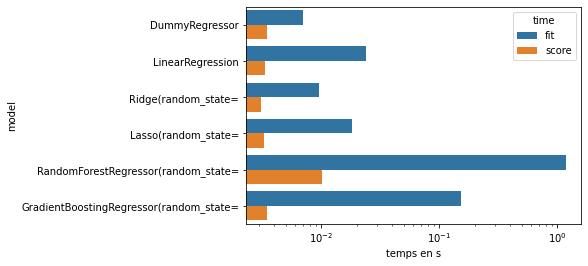

In [85]:
g = sns.barplot(x='temps en s', y='model', hue='time', data=df_time)
g.set(xscale="log")

Les modèles obtenant le meilleur r2 sont les modèles de random forest et de gradient boosting. D'un point de vue temps de calcul et temps d'excécution les résultats sont très dispersés, il faut même utiliser une échelle logarithmique pour pouvoir comparer les résultats. Le modèle de random forest est le plus lourd en temps de calcul. Ensuite viennent les modèles gradient boosting et Lasso. Enfin, les modèles de regression linéaire et Ridge sont bien plus léger, ils sont de 10 à 100 fois plus rapides.

On peut donc conclure que les deux modèles que nous allons étudier en détails sont :
* Random Forest
* Gradient boosting

### Comparaison des meilleurs modèles

Pour l'optimisation on utilise la fonction GridSearchCV qui permet de tester une liste d'hyper-paramètres en cross validation. 

Remarque : le nom du parametre doit commencer par nom du modèle + __ lorsque l'on utilise pipeline. ex : model__alpha

In [86]:
grid_list = []

#### Random Forest Regressor

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [87]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestRegressor(random_state=seed))])

testet 4 ou 5 hyper parametres

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Il existe de nombreux hyper-paramètres pour le model de random forest.

In [88]:
rf_pipeline['model'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

Afin de comparer les deux meilleurs modèles nous allons sélectionner seulement 5 hyper-paramètres à faire varier.

In [89]:
param_grid = {
    'model__criterion': ['mse', 'mae'],
    'model__max_depth': [None, 5, 10],
    'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 5, 10],
    'model__min_samples_split': [2, 10, 20],
}

On effectue GridSearchCV et on stocke les résultats dans une liste.

In [90]:
grid = GridSearchCV(rf_pipeline, param_grid, scoring='r2', cv=5, return_train_score=True)
grid.fit(X_train, y_train)
grid_list.append(grid)

#### Gradient Boosting

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [91]:
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', GradientBoostingRegressor(random_state=seed))])

Il existe de nombreux hyper-paramètres pour le model de gradient boosting.

In [92]:
gb_pipeline['model'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Afin de comparer les deux meilleurs modèles nous allons sélectionner seulement 5 hyper-paramètres à faire varier.

In [93]:
param_grid = {
    'model__max_depth': [None, 5, 10],    
    'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 5, 10],
    'model__min_samples_split': [2, 10, 20],
    'model__n_estimators': [50, 100, 150]
}

On effectue GridSearchCV et on stocke les résultats dans une liste.

In [94]:
grid = GridSearchCV(gb_pipeline, param_grid, scoring='r2', cv=5, return_train_score=True)
grid.fit(X_train, y_train)
grid_list.append(grid)

On compare les meilleurs résultats moyens pour chaque modèle.

In [95]:
df_score, df_time = best_grid(grid_list)

RandomForestRegressor
Meilleur score validation : 0.664
GradientBoostingRegressor
Meilleur score validation : 0.695


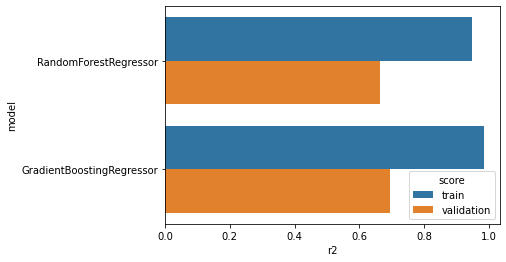

In [96]:
sns.barplot(x='r2', y='model', hue='score', data=df_score)

[None]

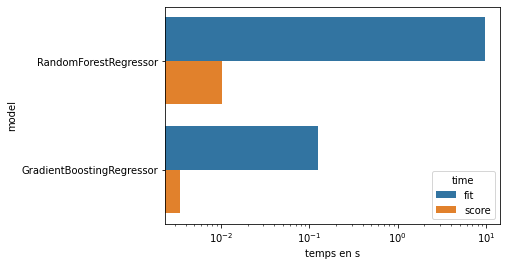

In [97]:
g = sns.barplot(x='temps en s', y='model', hue='time', data=df_time)
g.set(xscale="log")

On constate donc que le modèle ayant le meilleur score de validation est le modèle de gradient boosting. Pour avoir une idée des meilleurs hyper-paramètres ont peut afficher ceux qui ont été utilisés pour obtenir le meilleur score.

In [98]:
grid_list[1].best_estimator_['model'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [99]:
grid_list[1].best_params_

{'model__max_depth': 5,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

On stocke ce modèle.

In [100]:
model_gridcv = GradientBoostingRegressor(max_depth=grid_list[1].best_params_['model__max_depth'],
                                         max_features=grid_list[1].best_params_['model__max_features'],
                                         min_samples_leaf=grid_list[1].best_params_['model__min_samples_leaf'],
                                         min_samples_split=grid_list[1].best_params_['model__min_samples_split'],
                                         n_estimators=grid_list[1].best_params_['model__n_estimators'],
                                         random_state=seed)

### Optimisation du meilleur modèle

On a déterminé que le meilleur modèle était le modèle de gradient boosting. On va maintenant essayer de pousser plus loin l'optimisation de ce modèle en 3 étapes :
* Optimisation de l'encodage
* Optimisation plus complète des hyper-paramètres
* Optimisation des features

#### Etape 1 :  Optimisation de l'encodage des variables catégoriques

Liste des méthodes d'encodage que l'on va tester.

In [101]:
encoder_list = [ce.one_hot.OneHotEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.sum_coding.SumEncoder]

On effectue une cross validation pour chaque méthode d'encodage.

In [102]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

for encoder in encoder_list:

    categorical_transformer = Pipeline(steps=[('encoder', encoder())])

    preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', model_gridcv)])
    cv_results = cross_validate(model, X_train, y_train, scoring='r2', cv=5)
    print(encoder)
    print("average validation score: %.3f" % cv_results['test_score'].mean())

<class 'category_encoders.one_hot.OneHotEncoder'>
average validation score: 0.693
<class 'category_encoders.ordinal.OrdinalEncoder'>
average validation score: 0.581
<class 'category_encoders.sum_coding.SumEncoder'>
average validation score: 0.689


Pour la suite de cette étude nous utiliserons ma méthode One Hot.

In [103]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', ce.one_hot.OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', GradientBoostingRegressor(random_state=seed))])

#### Etape 2 :  Plage d'hyper-paramètres assez large

D'après les résultats des deux grid search, le meilleur modèle est le gradient boosting. Nous allons maintenant chercher à optimiser plus loin les hyper paramètres. Pour cela on va utiliser la méthode de random search.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

La différence entre RandomizedSearchCV et GridSearchCV est que l'on spécifie beaucoup plus de valeur dans notre grille d'hyper-paramètres avec RandomizedSearchCV. Cela prendrait trop de temps de d'entrainer et de tester l'ensemble des configurations, c'est pourquoi on fixe un nombre d'itérations à essayer.

On définit la plage à étudier des hyper-paramètres en se basant sur les valeurs par défaut et les valeurs ayant donné le meilleur score avec GridSearchCV : 
* learning_rate : [0.01 à 0.5 pas de 0.01]
* n_estimators : [20 à 80 pas de 1]
* min_samples_split :  [2]
* min_samples_leaf : [1 à 4 pas de 1]
* max_depth : [1 à 9 pas de 1]
* max_features : [5 à 15 pas de 1]
* max_leaf_nodes : [None]

Maintenant que l'on connait la plage la plus intéressante des hyper-paramètres, on cherche à trouver le meilleur jeu d'hyper-paramètres. Pour cela on effectue un dernier RandomizedSearchCV.

In [104]:
param_grid = {
    'model__learning_rate':[x*0.01 for x in np.linspace(start = 1, stop = 50, num = 50)],
    'model__n_estimators':[int(x) for x in np.linspace(start = 20, stop = 80, num = 61)],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [1,2,3,4],
    'model__max_depth': [int(x) for x in np.linspace(start=1, stop=9, num=9)],
    'model__max_features': [int(x) for x in np.linspace(start=5, stop=15, num=11)],
    'model__max_leaf_nodes': [None]
}

In [105]:
grid = RandomizedSearchCV(gb_pipeline, param_distributions=param_grid, n_iter=1000, scoring='r2', cv=5, return_train_score=True, random_state=seed)
grid.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['CouncilDistrictCode', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'NumberofFloors',
       'Latitude', 'Longitude', 'Gas', 'Steam', 'BuildingAge'],
      dtype='o...
                                        'model__max_depth': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'model__max_features': [5, 6, 7, 8, 9,
                                                              

In [106]:
grid.best_score_

0.7469695420596366

In [107]:
grid.best_params_

{'model__n_estimators': 35,
 'model__min_samples_split': 2,
 'model__min_samples_leaf': 2,
 'model__max_leaf_nodes': None,
 'model__max_features': 15,
 'model__max_depth': 3,
 'model__learning_rate': 0.26}

On stocke le modèle ayant obtenu le meilleur score moyen en cross-validation sur les 1000 itérations testées.

In [108]:
gb_best_params = GradientBoostingRegressor(n_estimators=35,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           max_leaf_nodes=None,
                                           max_features=15,
                                           max_depth=3,
                                           learning_rate=0.26,
                                           random_state=seed)

In [109]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', ce.one_hot.OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

gb_pipeline_opti = Pipeline(steps=[('preprocessor', preprocessor),('model', gb_best_params)])
cv_results = cross_validate(gb_pipeline_opti, X_train, y_train, scoring='r2', cv=5)
print("average validation score: %.3f" % cv_results['test_score'].mean())

average validation score: 0.747


#### Etape 3 : Features ayant le plus d'importance

Dans cette étape nous allons utiliser le meilleur modèle dont on dispose pour déterminer les features ayant le plus d'importance pour le modèle. Pour cela nous allons utiliser la fonction permutation_importance de scikit-learn de la même manière que pour la consommation d'énergie.

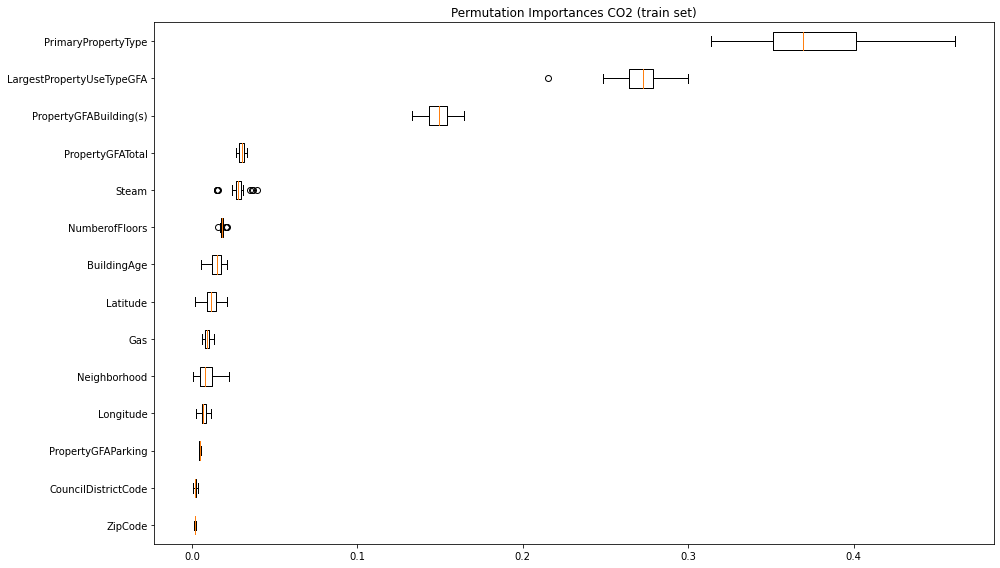

In [110]:
gb_pipeline_opti.fit(X_train, y_train)
result = permutation_importance(gb_pipeline_opti, X_train, y_train, n_repeats=30, n_jobs=2, random_state=seed)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14,8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances CO2 (train set)")
fig.tight_layout()
plt.show()


On constate plusieurs choses : 
* PrimaryPropertyType est également la variable la plus importante
* Ensuite viennent les variables de surface (excepté PropertyGFAParking):
    * LargestPropertyUseTypeGFA
    * PropertyGFABuilding(s)
    * PropertyGFATotal est moins important pour ce modèle par rapport au modèle de consommation d'énergie car son importance est proche des autres variables peu importantes

On va donc faire le même travail que pour la consommation d'énergie c'est-à-dire d'ajouter et de supprimer des features pour voir l'impact sur le score.

##### Suppression de features

In [111]:
X_train_surface = X_train.drop(axis='columns', columns=['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'PropertyGFAParking'])
X_test_surface = X_test.drop(axis='columns', columns=['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'PropertyGFAParking'])

##### Ajout de features

In [112]:
X_train_addBoS = addBuildingAgeOverSurface(X_train)
X_test_addBoS = addBuildingAgeOverSurface(X_test)

In [113]:
X_train_addSoB = addSurfaceOverBuildingAge(X_train)
X_test_addSoB = addSurfaceOverBuildingAge(X_test)

In [114]:
X_train_ENERGYSTARScore = X_train_knn.copy()
X_test_ENERGYSTARScore = X_test_knn.copy()

##### Comparaison avec cross-validation

On compare avec la cross-validation 5 modèles de gradient boosting ayant le meilleur jeu d'hyper-paramètres que l'on a obtenu à la suite de RandomizedSeachCV. Les différences entre ces modèles se trouvent dans les features :
* modèle optimisé : modèle de base avec 14 features 
* modèle optimisé une seule surface : modèle de base - 3 features de surface 
* modèle optimisé BuildingAge over Surface : modèle de base + 1 feature BuildingAge/PropertyGFABuilding(s)
* modèle optimisé Surface over BuildingAge : modèle de base + 1 feature PropertyGFABuilding(s)/BuildingAge
* modèle optimisé ENERGYSTARScore : modèle de base + 1 feature ENERGYSTARScore

In [115]:
df_score = pd.DataFrame(columns=['model','r2','score'])
df_score = evaluationPipeline(X_train, y_train, gb_best_params, 'Modèle optimisé', df_score)
df_score = evaluationPipeline(X_train_surface, y_train, gb_best_params, 'Modèle optimisé \n une seule surface', df_score)
df_score = evaluationPipeline(X_train_addBoS, y_train, gb_best_params, 'Modèle optimisé \n BuildingAge over Surface', df_score)
df_score = evaluationPipeline(X_train_addSoB, y_train, gb_best_params, 'Modèle optimisé \n Surface over BuildingAge', df_score)
df_score = evaluationPipeline(X_train_ENERGYSTARScore, y_train, gb_best_params, 'Modèle optimisé \n ENERGYSTARScore', df_score)

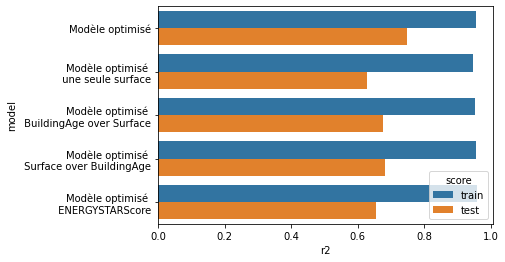

In [116]:
sns.barplot(x='r2', y='model', hue='score', data=df_score)

In [117]:
df_score.loc[df_score.score == 'test',:]

,model,r2,score
1,Modèle optimisé,0.746970,test
3,Modèle optimisé \n une seule surface,0.628569,test
5,Modèle optimisé \n BuildingAge over Surface,0.676491,test
7,Modèle optimisé \n Surface over BuildingAge,0.682406,test
9,Modèle optimisé \n ENERGYSTARScore,0.654002,test


On constate que le modèle obtenant le meilleur score est le modèle de base.

### Evaluation finale

On va donc maintenant effectuer l'évaluation sur le jeu de test.

#### Meilleur modèle

On redéfinit le meilleur modèle.

In [118]:
gb_best_params = GradientBoostingRegressor(n_estimators=35,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           max_leaf_nodes=None,
                                           max_features=15,
                                           max_depth=3,
                                           learning_rate=0.26,
                                           random_state=seed)

In [119]:
gb_pipeline_opti = preprocessingPipeline(X_train, gb_best_params)
cv_results = cross_validate(gb_pipeline_opti, X_train, y_train, scoring='r2', cv=5, return_train_score=True)
print("average validation score: %.3f" % cv_results['test_score'].mean())

average validation score: 0.747


#### Learning Curve

On s'intéresse également à la courbe d'apprentissage qui permet de voir si le modèle pourrait s'améliorer si l'on disposait de plus de données.

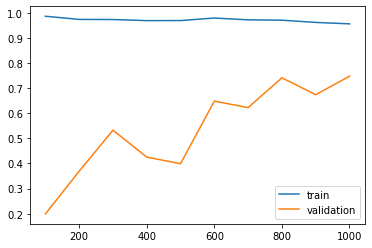

In [120]:
plotLearningCurve(gb_pipeline_opti, X_train, y_train)

On constate que le score de validation s'améliore lorsque l'on a plus de données. Cela signifie que l'on pourrait encore améliorer le score en ajoutant des données.

#### Evaluation sur le test set

On effectue l'évaluation finale sur le jeu de test.

In [121]:
gb_pipeline_opti.fit(X_train, y_train)
y_pred = gb_pipeline_opti.predict(X_test)
test_score = r2_score(y_test, y_pred)
print(f'Le score r2 du meilleur modèle est de {test_score:0.2f}')

Le score r2 du meilleur modèle est de 0.22


#### Evaluation du model selon une variable catégorielle

On calcule l'erreur relative que l'on va observer en fonction de l'usage des bâtiments.

In [122]:
df_score = X_test_knn.copy()
df_score.loc[:,'erreur relative sur les émissions de CO2 (%)'] = (y_pred - y_test)/abs(y_test) * 100
print('erreur relative moyenne (%) :')
print(round(df_score['erreur relative sur les émissions de CO2 (%)'].mean(),2))

erreur relative moyenne (%) :
79.02


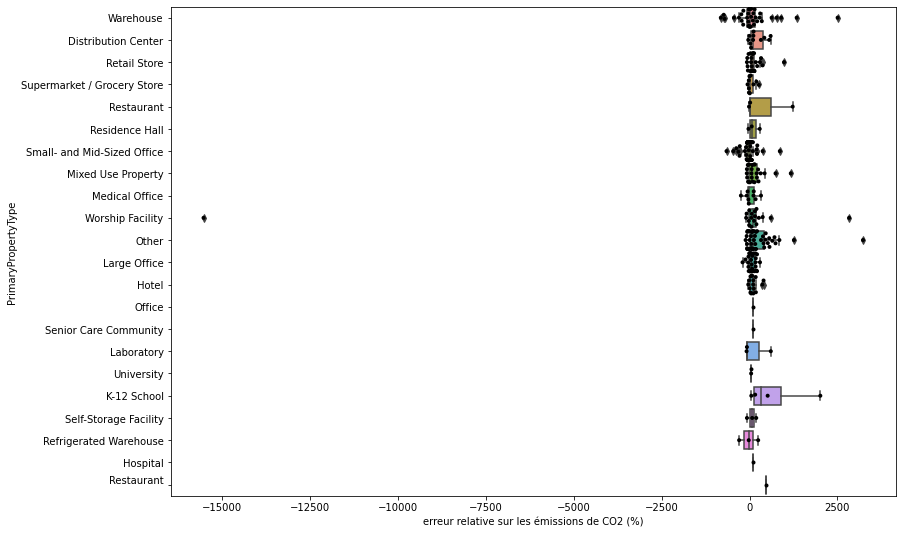

In [123]:
plt.figure(figsize=(13,9))
#sns.set(font_scale=1.2)
sns.boxplot(x='erreur relative sur les émissions de CO2 (%)', y='PrimaryPropertyType', data=df_score)
sns.swarmplot(x='erreur relative sur les émissions de CO2 (%)', y='PrimaryPropertyType', data=df_score, color='black', size=4)

On constate que l'erreur relative est très dispersée en fonction de l'usage des bâtiments. Certaines catégories ont peu de points ce qui pourrait expliquer cette disparité.

In [124]:
index_logic = (df_score.loc[:,'PrimaryPropertyType'] == 'Small- and Mid-Sized Office') | (df_score.loc[:,'PrimaryPropertyType'] == 'Large Office') | (df_score.loc[:,'PrimaryPropertyType'] == 'Hotel')

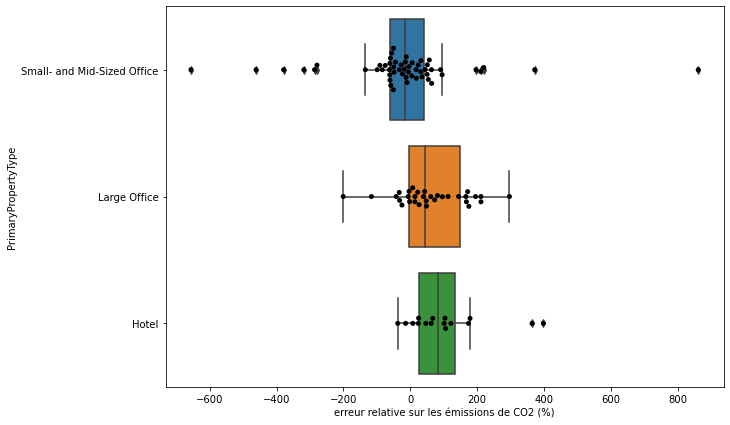

In [125]:
plt.figure(figsize=(10,7))
#sns.set(font_scale=1.4)
sns.boxplot(x='erreur relative sur les émissions de CO2 (%)', y='PrimaryPropertyType', data=df_score.loc[index_logic,:])
sns.swarmplot(x='erreur relative sur les émissions de CO2 (%)', y='PrimaryPropertyType', data=df_score.loc[index_logic,:], color='black')

In [126]:
df_score.loc[index_logic,['erreur relative sur les émissions de CO2 (%)','PrimaryPropertyType']].groupby('PrimaryPropertyType').mean()

,erreur relative sur les émissions de CO2 (%)
PrimaryPropertyType,
Hotel,107.661862
Large Office,61.098726
Small- and Mid-Sized Office,-20.066327


On constate que l'erreur relative est plus importante que pour la consommation d'énergie.